# Spaceship Titanic

For my final project in this class, I decided to try and build on a Kaggle competition that I completed for my final project in the Supervised Learning class. Now that I've learned some more techniques, I wanted to see if I could apply those to improve my result from my first attempt. I ended up trying to solve the Spaceship Titanic challenge. The goal for this challenge was to classify passengers based on whether or not they were transported to an alternate dimension when the spaceship encountered a spacetime anomoly. For this challenge, accuracy is the key measure so all of my models were measured on their accuracy against the training data.

Here is a link to the page with the challenge: https://www.kaggle.com/competitions/spaceship-titanic

In my first attempt at this competition, I learned that the most critical part of my analysis was something we hadn't covered in the Supervised Learning class (and that we still haven't really covered after Unsupervised Learning) and that was how to impute missing values. The data we are given contains passenger records for the passengers that were on the Spaceship Titanic, but many of those values are missing from the data. If we had no missing values, it would be pretty easy to train a random forest or SVM model and attain a high accuracy in the Kaggle competition. But since there is missing data, the accuracy of our models is completely dependent on how well we can impute the missing data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier

## Data

In [2]:
data_train = pd.read_csv("spaceship-titanic/train.csv")
data_test = pd.read_csv("spaceship-titanic/test.csv")

print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


The first thing we can notice is that there are a mix of data types in the columns with some object and some numeric columns. Based on the description of the columns from the challenge page on Kaggle, we can look at some of the categorical columns and determine what values are used.

Here are the descriptions from Kaggle:

- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

We also notice in the Non-Null Count column that each column has a different value there. Those shows that with the exception of the PassengerId and Transported columns, there are missing values in all the rest. The training data has 8,693 records and while it's not a lot of records that are missing values, we are still missing enough data that we need imputation before we can train our models.

Now that we know what type of values are saved in each column, let's look at the actual values themselves for the object DType columns. We can skip over Name and Age since that will be unique to each passenger. We are really more interested in things like HomePlanet, Destination, and CryoSleep. Let's write a function to do this and we will use it later.

In [3]:
def print_unique_values(data):
    """
    Prints unique values for each column
    """
    for col in data.columns:
        if col != "Name" and col != "Age":
            print(col + ": " + str(data[col].unique()))


print_unique_values(data_train)

PassengerId: ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
HomePlanet: ['Europa' 'Earth' 'Mars' nan]
CryoSleep: [False True nan]
Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP: [False True nan]
RoomService: [   0.  109.   43. ... 1569. 8586.  745.]
FoodCourt: [   0.    9. 3576. ... 3208. 6819. 4688.]
ShoppingMall: [   0.   25.  371. ... 1085.  510. 1872.]
Spa: [   0.  549. 6715. ... 2868. 1107. 1643.]
VRDeck: [   0.   44.   49. ... 1164.  971. 3235.]
Transported: [False  True]


Moving on to our EDA, we can already see two things we will need to change.

The first is the PassengerId column. From the descriptions, we know that this is made up of a group and a number, where the first four digits in the number signify the group and the last two numbers signifiy that passenger within the group. We will separate this into two columnns for our analysis.

The second is the Cabin column. This is also a concatenation of a few different values. We will separate this column into Deck, Num, and Side for our EDA.

## Approach/EDA

Since the most critical part of this Kaggle competition is the imputation of missing values, we will focus on different ways to do that using unsupervised learning strategies, and then we will use a few different models to analyze the performance of both the imputation and of the models themselves. But first, we can display some info about the missing values.

Percentage of records missing at least one feature: 24.01%



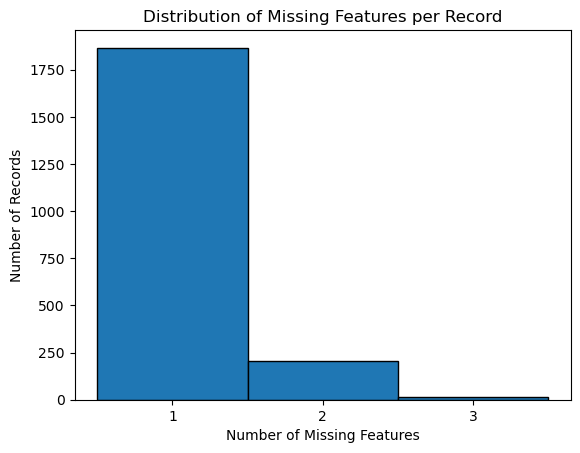

In [4]:
# calculate and show number of records missing certain number of features

total_records = len(data_train)
num_missing_features = data_train.isnull().sum(axis=1)
num_missing_features_not_zero = num_missing_features[num_missing_features > 0]
percent_records_missing_value = len(num_missing_features_not_zero) / total_records

print(f"Percentage of records missing at least one feature: {percent_records_missing_value:.2%}")
print()

plt.hist(num_missing_features_not_zero, bins=range(1, num_missing_features_not_zero.max() + 2), edgecolor='black', align='left')
plt.title("Distribution of Missing Features per Record")
plt.xlabel("Number of Missing Features")
plt.ylabel("Number of Records")
plt.xticks(range(1, num_missing_features_not_zero.max() + 1))
plt.show()

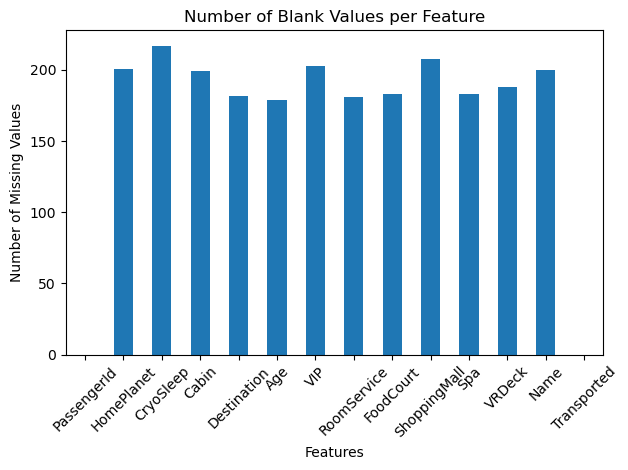

In [5]:
# show distribution of missing values per features

missing_per_feature = data_train.isnull().sum()

missing_per_feature.plot(kind="bar")
plt.title("Number of Blank Values per Feature")
plt.xlabel("Features")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: >

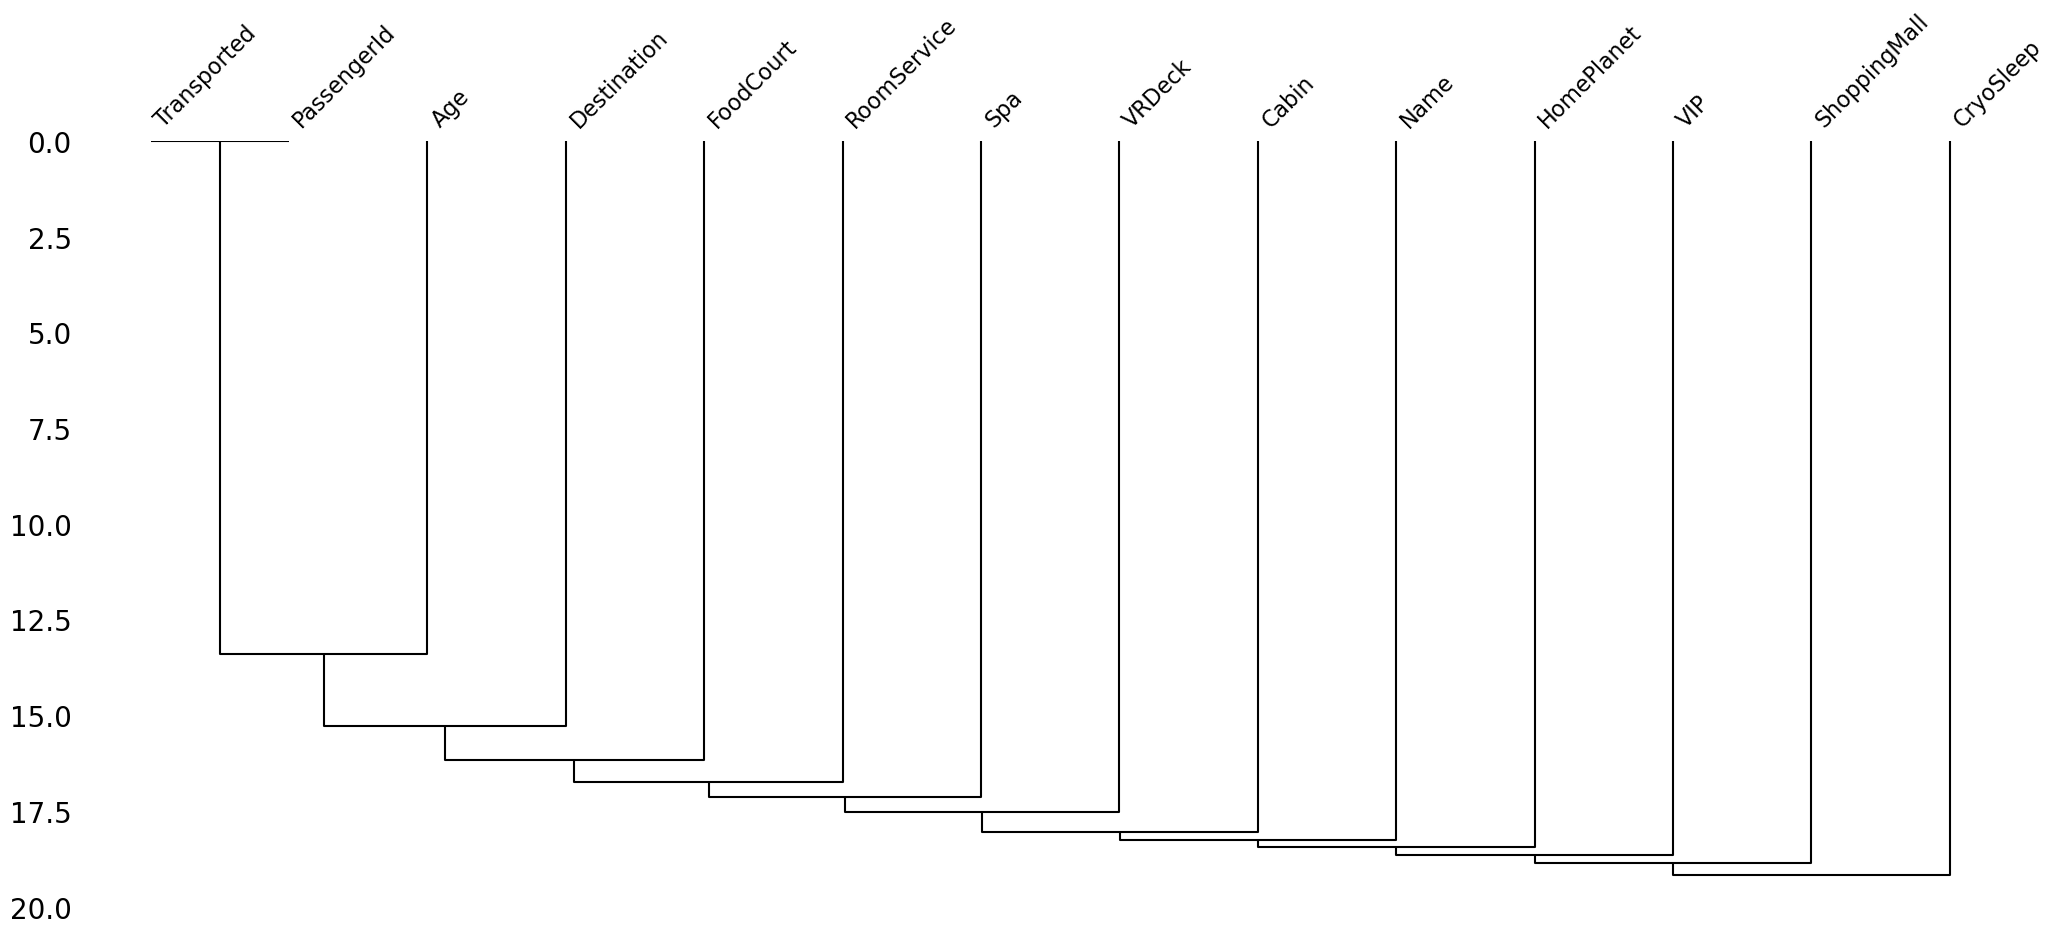

In [6]:
# show dendrogram of missing values

msno.dendrogram(data_train)

To reiterate, the main issue I ran into when I was using my supervised learning models was that I didn't know of a good way to impute missing values. We could analyze this data manually and determine if there are any patterns we could use for imputation but that would be difficult as we might miss some of those patterns and that would take quite a long time to determine all of them. As we saw above, we're missing about 2,000 items across all passengers and features. There may be some overlap between them and we may be able to impute several of them at once if we determine a pattern but to impute all 2,000 would take quite some time. And the whole point of computer science is to learn how to solve these types of problems in an efficient and scalable way, so we will try to use unsupervised learning strategies to do that.

## Data Cleanup

In order to clean up the data, there are a few steps I took:
1. Split the Cabin column into three different columns based on the "/" delimiter. New columns added were Deck, Num, and Side. After this, the original Cabin column was removed
2. Add columns for the Group number and Person number by splitting the PassengerId column and then removing it.
3. Drop unnecessary columns that would just add noise to our imputation methods (Name and Age)
4. "Numericize" our data. Since both our imputation methods and models can only deal with numeric data, we need to convert the textual data to numbers.

Overall, these steps are similar to the steps taken to clean the data in my last project but our modified slightly to account for our different approach this time.

In [7]:
def clean_data(data, numericize=True):
    """
    Splits columns in the data that should be separated for easier analysis
    And converts non-numeric data to numbers for use by imputers if numericize is True
    """
    # split Cabin column into columns for Deck, Num, and Side
    data[["Deck", "Num", "Side"]] = data["Cabin"].str.split("/", expand=True)
    data = data.drop(["Cabin"], axis=1)

    # split PassengerId column
    data[["Group", "Person"]] = data["PassengerId"].str.split("_", expand=True)
    data = data.drop(["PassengerId"], axis=1)
    
    # drop these columns, shouldn't matter for predictions
    data = data.drop(["Name", "Age"], axis=1)
    
    if numericize:
        # loop through columns in dataframe
        for col in data.columns:
            
            # if col dtype is object or boolean, convert to numeric values
            if data[col].dtype == "object":
                data[col] = pd.factorize(data[col])[0]
            elif data[col].dtype == "bool":
                data[col] = data[col].astype(int)

    return data

After we clean up the data, we are going to try several different imputation methods using unsupervised learning strategies. Here is a summary of what we will do:
1. SKLearn's iterative imputer - This will iteratively impute missing values by treating the missing value as the target value and records without missing values as predictor variables
2. SKLearn's KNN imputer - this imputes missing values by comparing them to their k-nearest neighbors
3. Matrix Factorization - similar to how we tried to apply this to recommender systems in our week 4 assignment, we will see if we are able to impute missing values, testing both SVD and NMF, by using matrix factorization and then reconstructing the original matrix

## Impute Missing Values

In [8]:
def impute_data_iterative(data):
    """
    Impute missing data using sklearn's iterative imputer
    """
    # compute min and max values of features to use in imputer
    min_value = np.zeros(data.shape[1])
    max_value = np.array([max(data[col]) for col in data.columns])

    # create imputer
    imputer = IterativeImputer(missing_values=-1, max_iter=1000, initial_strategy="most_frequent", min_value=min_value, max_value=max_value)

    # save column names for later
    cols = data.columns

    # fill nan columns with -1
    for col in cols:
        data.fillna({col: -1}, inplace=True)

    data = imputer.fit_transform(data)
    # convert data to integers, imputer will populate float by default but that doesn't make sense
    # because we are actually dealing with categorical data
    data = np.round(data).astype(int)
    data = pd.DataFrame(data, columns=cols)
    
    return data

In [9]:
def impute_data_KNN(data):
    """
    Imputes missing data using K nearest neighbors
    """
    # create imputer
    imputer = KNNImputer(missing_values=-1, n_neighbors=1, weights="distance", copy=False)
    
    # save column names for later
    cols = data.columns

    # fill nan columns with -1
    for col in cols:
        data.fillna({col: -1}, inplace=True)
    
    data = imputer.fit_transform(data)
    # convert data to integers, imputer will populate float by default but that doesn't make sense
    # because we are actually dealing with categorical data
    data = np.round(data).astype(int)
    data = pd.DataFrame(data, columns=cols)
    
    return data

In [10]:
def impute_data_using_matrix(input_data):
    """
    Try to impute missing values by using matrix factorization to predict missing values
    """    
    data = input_data.copy()
    
    data = clean_data(data, numericize=False)
    
    # let's group records together based on missing values, these will serve as our test data
    missing_values_dict = {}
    for col in data.columns:
        if data[col].isnull().any():
            missing_values_dict[col] = data[data[col].isnull()].index.tolist()
    
    
    # loop through columns in dataframe
    for col in data.columns:
        
        # if col dtype is object or boolean, convert to numeric values
        # add one to each column so that 0 represents nan values instead of -1
        # this will allow nmf to work with this data
        if data[col].dtype == "object":
            data[col] = pd.factorize(data[col])[0] + 1
        elif data[col].dtype == "bool":
            data[col] = data[col].astype(int) + 1
            
        # if numeric, replace nan values with 0
        elif data[col].dtype == "float64":
            data[col] + 1
            data.fillna({col: 0}, inplace=True)
    
    
    nmf_data = data.copy()
    svd_data = data.copy()
    
    
    # fit nmf model
    nmf_model = NMF(random_state=42)
    nmf_model.fit(nmf_data)
    
    W = nmf_model.transform(nmf_data)
    H = nmf_model.components_ 

    nmf_predict_matrix = W @ H
    
    for key, vals in missing_values_dict.items():
        for val in vals:
            nmf_data.loc[val, key] = nmf_predict_matrix[val, nmf_data.columns.get_loc(key) -1].astype(nmf_data[key].dtype)
    
    # fit svd model
    U, s, Vt = np.linalg.svd(svd_data.drop(["Transported"], axis=1))
    s_diag = np.zeros(svd_data.drop(["Transported"], axis=1).shape)
    s_diag[:svd_data.shape[1]-1, :svd_data.shape[1]-1] = np.diag(s)
    svd_predict_matrix = U.dot(s_diag).dot(Vt)
    
    for key, vals in missing_values_dict.items():
        for val in vals:
            svd_data.loc[val, key] = svd_predict_matrix[val, svd_data.columns.get_loc(key) -1].astype(nmf_data[key].dtype)
    
    return nmf_data, svd_data

It's worth mentioning that we've specifically selected certain hyperparameters for both the iterative imputer and KNN imputer. Here are the more important selections and why we've selected them:
- Iterative imputer
    - initial_strategy="most_frequent": by default, this parameter is set to "mean" but since we are dealing with categorical data, we don't need to use floating numbers. Instead we will take the most frequent value and calculate from there
    - min_value and max_value: we will set these to make sure that they stay within the expected ranges of the categorical data. For example, there are only 3 home planets, encoded to 0, 1, and 2. So we should not see a 3 after imputation because this would be for a planet that does not exist in the original data
- KNN Imputer
    - n_neighbors=1: this is the hyperparameter that might be most susceptible to tuning. However, in my manual experimentation, 1 yielded the best results so we will use it. This means that the imputer will take the single closest neighbor to the target and use those values for imputation
    - weights="distance": this controls how the nearest points are weighted. The other option is "uniform", which weights points in a neighborhood equally. But since we are concerned with how similar the very closest points are, we will set this to "distance" which weighs points based on their distance from the target

Now, let's take a look at our unique values after we've cleaned the data, and after we've used SKLearn's built-in imputation methods.

In [11]:
print("unique values for standard data:\n")
print_unique_values(data_train)

unique values for standard data:

PassengerId: ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
HomePlanet: ['Europa' 'Earth' 'Mars' nan]
CryoSleep: [False True nan]
Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP: [False True nan]
RoomService: [   0.  109.   43. ... 1569. 8586.  745.]
FoodCourt: [   0.    9. 3576. ... 3208. 6819. 4688.]
ShoppingMall: [   0.   25.  371. ... 1085.  510. 1872.]
Spa: [   0.  549. 6715. ... 2868. 1107. 1643.]
VRDeck: [   0.   44.   49. ... 1164.  971. 3235.]
Transported: [False  True]


In [12]:
clean_train = clean_data(data_train)
print("unique values for clean data:\n")
print_unique_values(clean_train)

unique values for clean data:

HomePlanet: [ 0  1  2 -1]
CryoSleep: [ 0  1 -1]
Destination: [ 0  1  2 -1]
VIP: [ 0  1 -1]
RoomService: [   0.  109.   43. ... 1569. 8586.  745.]
FoodCourt: [   0.    9. 3576. ... 3208. 6819. 4688.]
ShoppingMall: [   0.   25.  371. ... 1085.  510. 1872.]
Spa: [   0.  549. 6715. ... 2868. 1107. 1643.]
VRDeck: [   0.   44.   49. ... 1164.  971. 3235.]
Transported: [0 1]
Deck: [ 0  1  2  3 -1  4  5  6  7]
Num: [   0    1    2 ... 1814 1815 1816]
Side: [ 0  1 -1]
Group: [   0    1    2 ... 6214 6215 6216]
Person: [0 1 2 3 4 5 6 7]


In [13]:
imputed_iterative_train = impute_data_iterative(clean_train)
print("unique values for iteratively imputed data:\n")
print_unique_values(imputed_iterative_train)

unique values for iteratively imputed data:

HomePlanet: [0 1 2]
CryoSleep: [0 1]
Destination: [0 1 2]
VIP: [0 1]
RoomService: [   0  109   43 ... 1569 8586  745]
FoodCourt: [   0    9 3576 ... 3208 6819 4688]
ShoppingMall: [   0   25  371 ... 1085  510 1872]
Spa: [   0  549 6715 ... 2868 1107 1643]
VRDeck: [   0   44   49 ... 1164  971 3235]
Transported: [0 1]
Deck: [0 1 2 3 4 5 6 7]
Num: [   0    1    2 ... 1814 1815 1816]
Side: [0 1]
Group: [   0    1    2 ... 6214 6215 6216]
Person: [0 1 2 3 4 5 6 7]


In [14]:
imputed_KNN_train = impute_data_KNN(clean_train)
print("unique values for KNN imputed data:\n")
print_unique_values(imputed_KNN_train)

unique values for KNN imputed data:

HomePlanet: [0 1 2]
CryoSleep: [0 1]
Destination: [0 1 2]
VIP: [0 1]
RoomService: [   0  109   43 ... 1003 8586  745]
FoodCourt: [   0    9 3576 ... 3208 6819 4688]
ShoppingMall: [   0   25  371 ... 1085  510 1872]
Spa: [   0  549 6715 ... 2868 1107 1643]
VRDeck: [   0   44   49 ... 1164  971 3235]
Transported: [0 1]
Deck: [0 1 2 3 4 5 6 7]
Num: [   0    1    2 ... 1814 1815 1816]
Side: [0 1]
Group: [   0    1    2 ... 6214 6215 6216]
Person: [0 1 2 3 4 5 6 7]


These look good from a high-level. We don't have any negative or nan values so the imputers have successfully imputed missing data. But until we test some models against the training data, we won't know how accurate this imputation is. And how about the matrix factorization methods? What values have those imputed?

In [15]:
imputed_nmf_train, imputed_svd_train = impute_data_using_matrix(data_train)

print("unique values for NMF imputed data:\n")
print_unique_values(imputed_nmf_train)
print()

unique values for NMF imputed data:

HomePlanet: [1 2 3 0]
CryoSleep: [1 2 0 3 5 4]
Destination: [1 2 3 0 4]
VIP: [1 2 0 3 4]
RoomService: [   0.  109.   43. ... 1569. 8586.  745.]
FoodCourt: [   0.    9. 3576. ... 3208. 6819. 4688.]
ShoppingMall: [   0.   25.  371. ... 1085.  510. 1872.]
Spa: [   0.  549. 6715. ... 2868. 1107. 1643.]
VRDeck: [   0.           44.           49.         ...  971.           10.99907501
 3235.        ]
Transported: [1 2]
Deck: [1 2 3 4 0 5 6 7 8]
Num: [   1    2    3 ... 1815 1816 1817]
Side: [ 1  2  0  6  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Group: [   1    2    3 ... 6215 6216 6217]
Person: [1 2 3 4 5 6 7 8]



In [16]:
print("unique values for SVD imputed data:\n")
print_unique_values(imputed_svd_train)
print()

unique values for SVD imputed data:

HomePlanet: [1 2 3 0 5 6 4]
CryoSleep: [1 2 0 3]
Destination: [1 2 3 0]
VIP: [1 2 3 0]
RoomService: [   0.  109.   43. ... 1569. 8586.  745.]
FoodCourt: [   0.    9. 3576. ... 3208. 6819. 4688.]
ShoppingMall: [   0.   25.  371. ... 1085.  510. 1872.]
Spa: [   0.  549. 6715. ... 2868. 1107. 1643.]
VRDeck: [ 0.00000000e+00  4.40000000e+01  4.90000000e+01 ... -8.16370569e-13
  1.10000000e+01  3.23500000e+03]
Transported: [1 2]
Deck: [1 2 3 4 0 5 6 7 8]
Num: [   1    2    3 ... 1815 1816 1817]
Side: [1 2 0]
Group: [   1    2    3 ... 6215 6216 6217]
Person: [1 2 3 4 5 6 7 8]



Using these maxtrix factorization methods has yielded some interesting results. In both cases, we have categorical data where we know what the "min" and "max" values should be because we encoded those values to numbers. Both matrix factorization methods have added some values to these categories. NMF is showing more than two values for several of our boolean categories, such as CryoSleep, VIP, and Side. Side should only have two possible choices (Port or Starboard, encoded to 0 or 1) but NMF has calculated an additional 27 choices for that category! SVD similarly is calculating more than two values for some of our binary categories. But why is this happening?

I had thought that maybe these methods would work better now that we had data which is pretty dense. For our recommender systems test in a previous assignment, NMF did not work well for predicting missing values in our rating matrix because the data was so sparse and this lack of data was skewing the calculations. This Spaceship Titanic data is much denser than that rating matrix but both NMF and SVD have failed to correctly impute missing values. This is likely due to the fact that these calculations are mathematical in nature, and do not give us an easy way to impose certain restrictions on the values that are imputed. They are not algorithms in the same way that the SKLearn's imputers are and this has resulted in imputation of data that isn't useful to us because we know certain imputed values should not exist in the data. So while NMF and SVD may be more adept at imputing values that are numerical and not limited to integers, they are less adept at imputing values that are simply numerical representations of categorical data.

Seeing as how we're not confident using matrix factorization to impute missing values, let's continue on with our other imputation methods and see how they perform.

Now that we've got data imputed using both iterative and KNN imputation, let's see if we find anything interesting in some correlation matrices.

correlation matrix for iterative imputation:


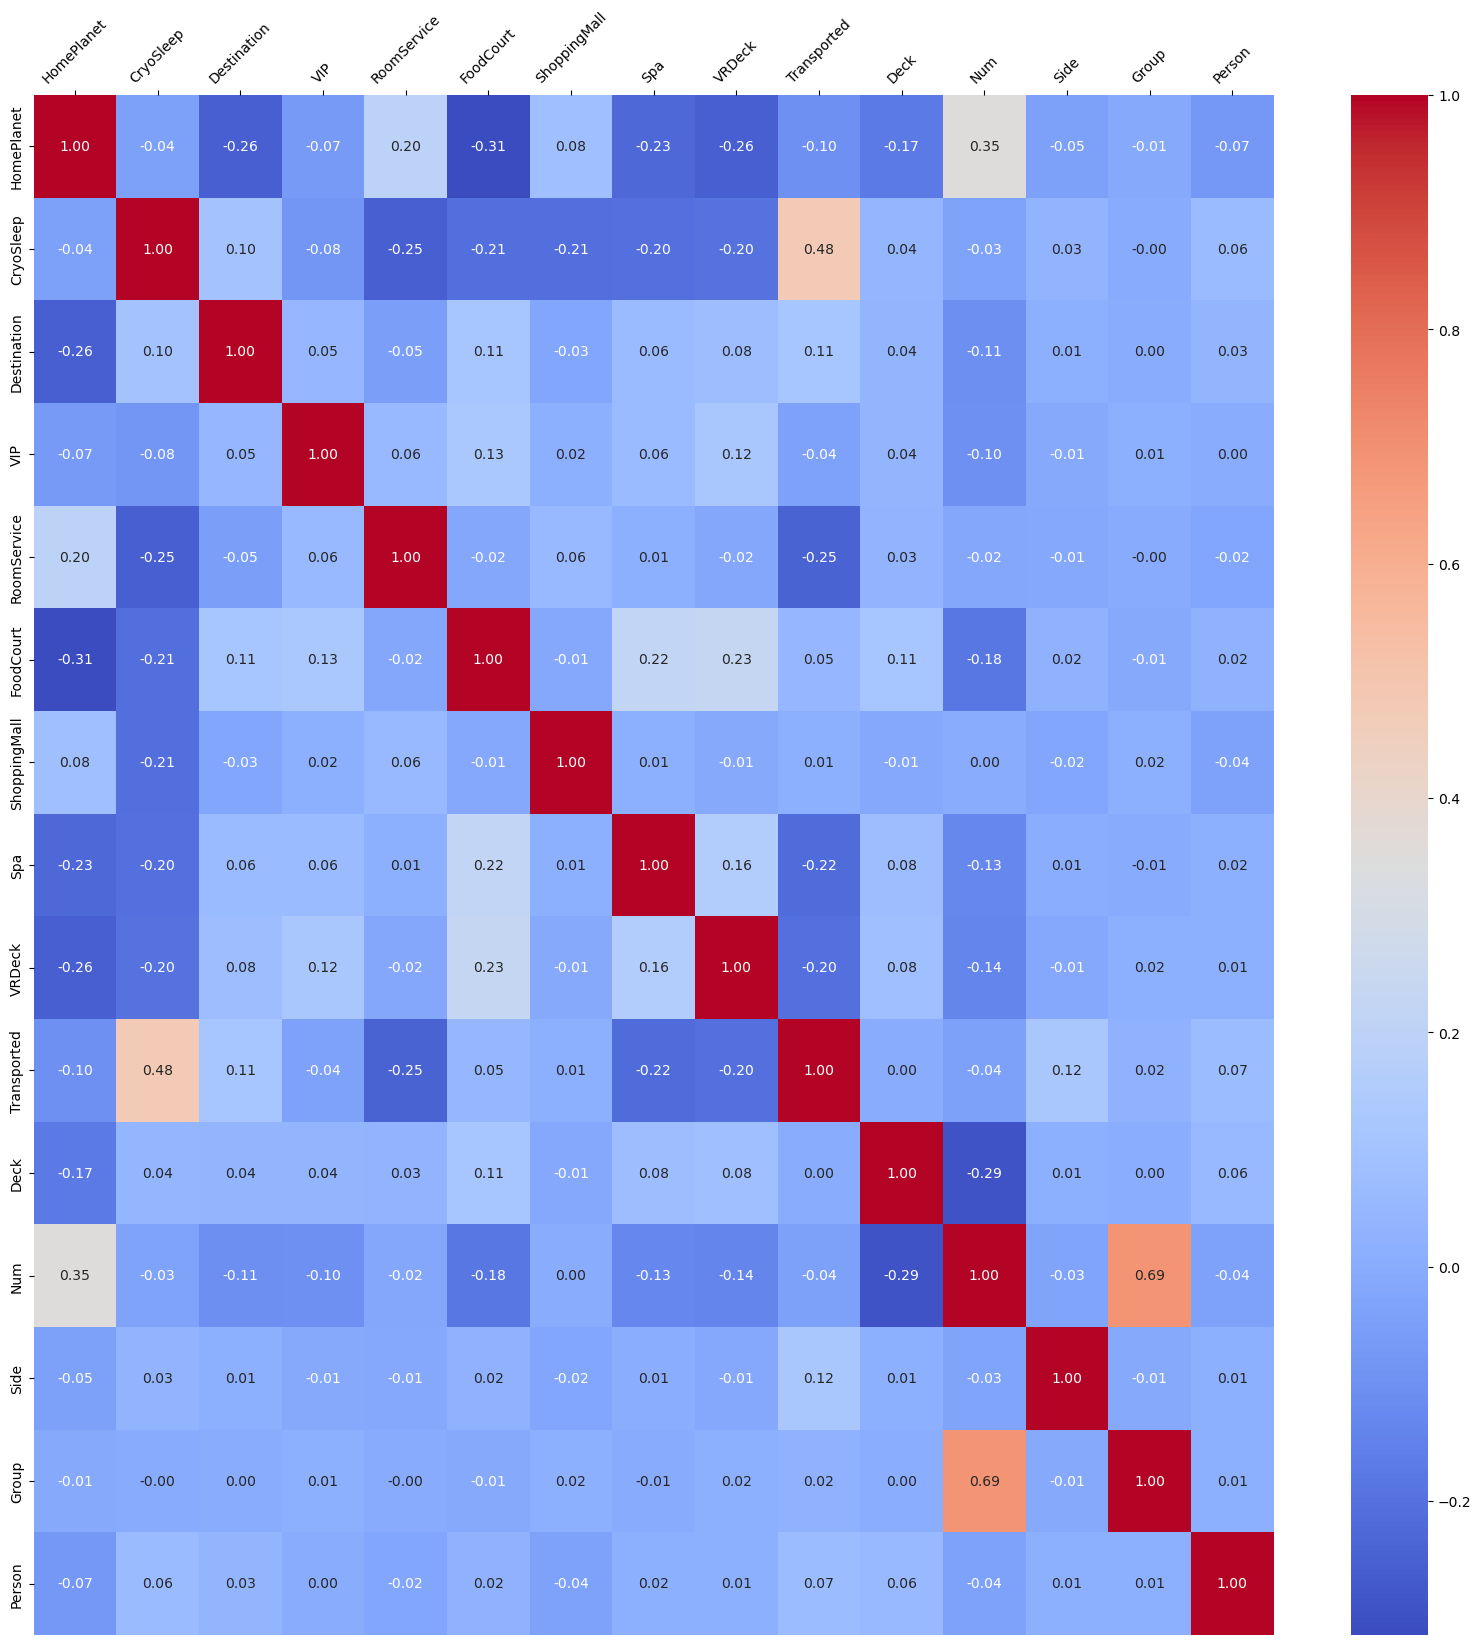

In [17]:
print("correlation matrix for iterative imputation:")
train_corr = imputed_iterative_train.corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.set_ticks_position("top")
sns.heatmap(data=train_corr, cmap="coolwarm", annot=True, fmt=".2f", ax=ax)
plt.xticks(rotation=45)
plt.show()

correlation matrix for KNN imputation:


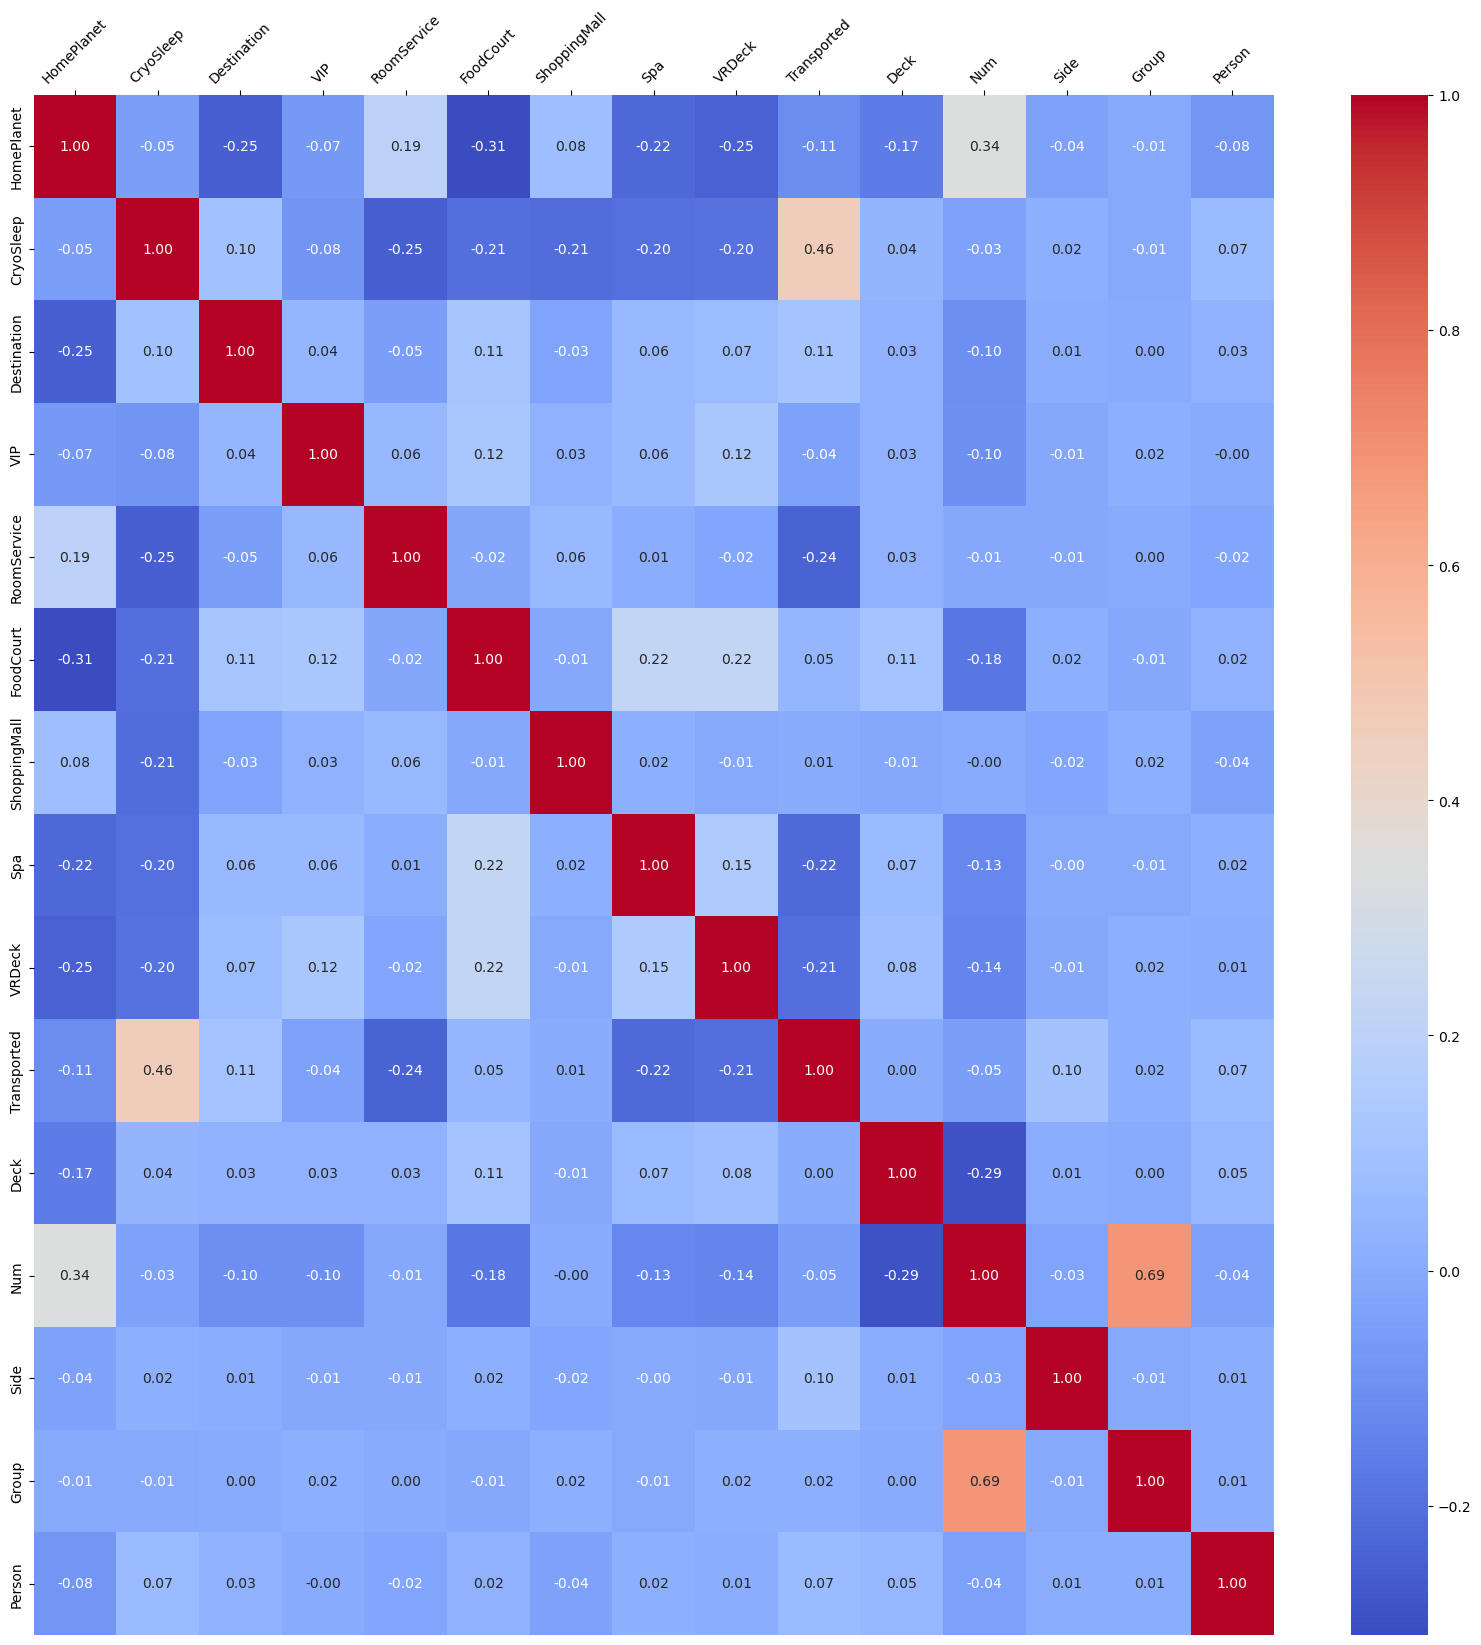

In [18]:
print("correlation matrix for KNN imputation:")
train_corr = imputed_KNN_train.corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.set_ticks_position("top")
sns.heatmap(data=train_corr, cmap="coolwarm", annot=True, fmt=".2f", ax=ax)
plt.xticks(rotation=45)
plt.show()

Our independent variable is the Transported column and we don't see anything that's highly correlated with that feature. CryoSleep is most highly correlated but that value is still below 0.5 so it's not a strong correlation, suggesting we can't use any individual features to accurately predict our independent variable and we have to use all of them.

Let's start with some helper functions to get an idea of which imputation method gtives us the best result and we will test a few different models to do that. The models we have chosen to use are as follows:

- Hierarchical clustering (SKLearn's AgglomerativeClustering)
- k-Nearest Neighbors clustering (SKLearn's KMeans)
- Non-negative matrix factorization (SKLearn's NMF)
- Random Forest (SKLearn's RandomForestClassifier - this will serve as a baseline for comparison to the unsupervised models above)

In [19]:
# from week 2 clustering assignment
import itertools

def label_permute_compare(ytdf,yp,n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    label_idx = range(n)
    k = len(yp)
    permutations = itertools.permutations(label_idx, n)
    labels = ytdf["Transported"].unique()
    
    output_perm = None
    accuracy = -1
    
    for perm in permutations:
        temp_list = list(yp)
        temp_count = 0
        
        for i in range(k):
            temp_list[i] = labels[perm[yp[i]]]
            if temp_list[i] == ytdf.at[i, "Transported"]:
                temp_count += 1
        
        if temp_count / k > accuracy:
            output_perm = perm
            accuracy = temp_count / k
    
    return output_perm, accuracy


def initialize_models():
    """
    initializes models for use by other functions
    """
    h_model = AgglomerativeClustering(n_clusters=2)
    k_model = KMeans(n_clusters=2)
    nmf_model = NMF(n_components=2, random_state=42)
    forest_model = RandomForestClassifier()
    
    return h_model, k_model, nmf_model, forest_model


def model_train(model, X_train, y_train=None):
    """
    Given a model and training data, fits the model on the training data and returns the model
    """
    if y_train is None:
        return model.fit(X_train)
    else:
        return model.fit(X_train, y_train)

In [20]:
def build_summary_dict(imputation_methods, data):
    """
    Builds and returns a dictionary using various data imputation methods
    """
    output_dict = {}
    
    for i in range(len(imputation_methods)):
        
        # initialize models
        h_model, k_model, nmf_model, forest_model = initialize_models()
        
        # train models
        y = data[i]["Transported"].values
        y = np.array(pd.to_numeric(y))
        X = data[i].drop(["Transported"], axis=1).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        
        h_model = model_train(h_model, data[i])
        k_model = model_train(k_model, data[i])
        if imputation_methods[i] != "singular value decomposition":
            nmf_model = model_train(nmf_model, data[i])
            
        forest_model = model_train(forest_model, X_train, y_train)
        
        # get model acc
        h_acc = label_permute_compare(data[i], h_model.labels_)[1]
        k_acc = label_permute_compare(data[i], k_model.labels_)[1]
        if imputation_methods[i] != "singular value decomposition":
            nmf_acc = label_permute_compare(data[i], nmf_model.transform(data[i]).argmax(axis=1))[1]
        else:
            nmf_acc = "N/A"
            
        forest_acc = accuracy_score(y_test, forest_model.predict(X_test))
        
        temp_dict = {
                    "hierarchical": h_acc,
                    "KNN": k_acc,
                    "NMF": nmf_acc,
                    "random forest": forest_acc
                    }
        
        output_dict[imputation_methods[i]] = temp_dict
    
    return output_dict
    

Now, we already know that our NMF and SVD imputation methods won't work well but since we've already done the imputation, it's easy enough to test our unsupervised models on that imputed data and see what we get. So let's use the above method to create and print out a dictionary that measures accuracy for each of our four models against each of our four imputation methods.

Just to note, I've chosen not to test the NMF model against SVD imputation because the SVD imputation can result in negative values being imputed, which won't work with the NMF model.

In [22]:
summary_dict = build_summary_dict(["iterative", "K nearest neighbors", "non-negative matrix", "singular value decomposition"],
                                  [imputed_iterative_train, imputed_KNN_train, imputed_nmf_train, imputed_svd_train],
                                  )

for method, acc_dict in summary_dict.items():
    print()
    print(f"imputation method: {method}\n")
    for model, acc in acc_dict.items():
        print(f"{model}: {acc}")
        
    print()


imputation method: iterative

hierarchical: 0.5162774646267112
KNN: 0.5197285171977453
NMF: 0.5346830783388934
random forest: 0.7912593444508338


imputation method: K nearest neighbors

hierarchical: 0.5594156217646382
KNN: 0.500402622799954
NMF: 0.5345680432531922
random forest: 0.7947096032202415


imputation method: non-negative matrix

hierarchical: 0.5040837455423904
KNN: 0.5190383066835385
NMF: 0.5235246750258828
random forest: 0.7958596894767107


imputation method: singular value decomposition

hierarchical: 0.5171977453123202
KNN: 0.5188082365121363
NMF: N/A
random forest: 0.7918343875790684



Analyzing these, it doesn't seem like our unsupervised models are going to be particularly effective no matter which imputation method we want to use. The accuracy is right around 0.5 for all of them. Given that this is an exercise in binary classification, we might be able to accomplish a higher accuracy simply by guessing randomly.

We can also see that imputation using KNN is more accurate for most models when tested against our training data. To double check this, I generated prediction files using these imputation methods and was able to confirm that using most models (random forest especially) KNN imputation performed better than iterative:

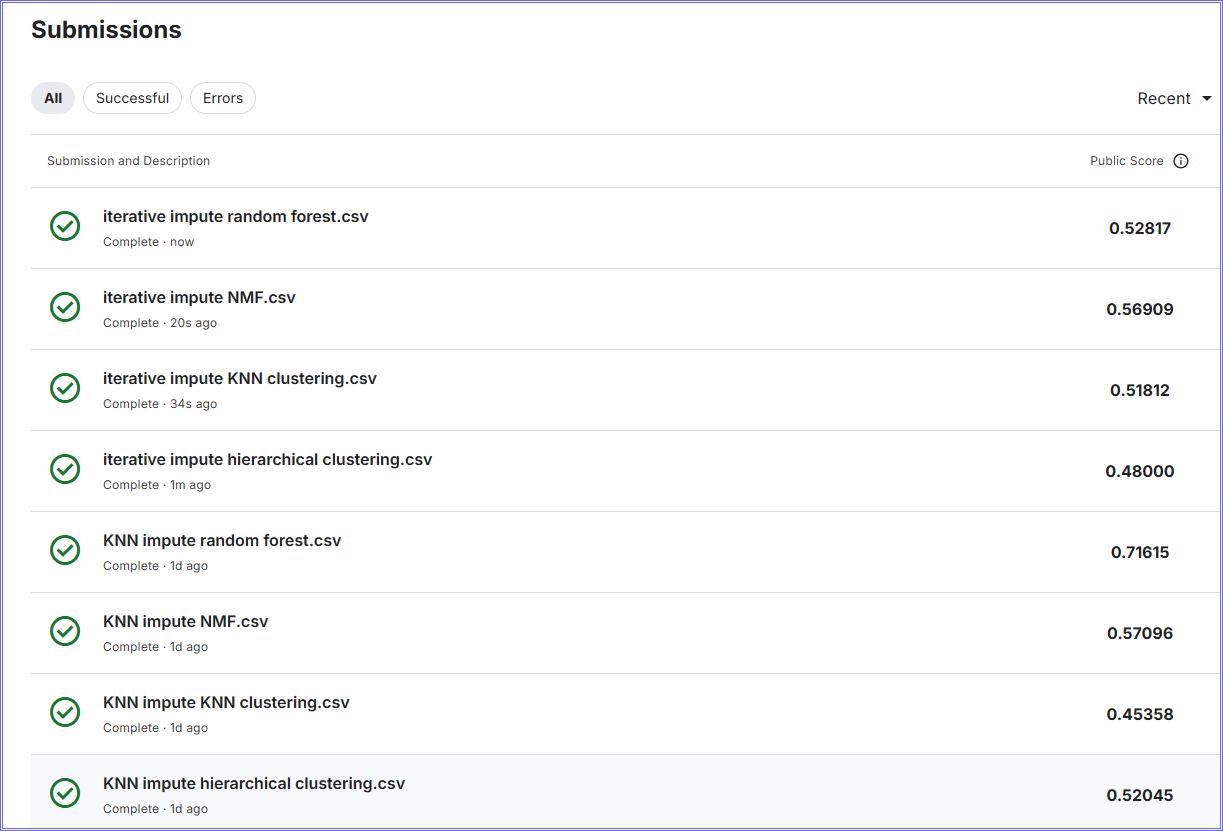

Just to see this more clearly, let's plot these accuracies taken from Kaggle uploads.

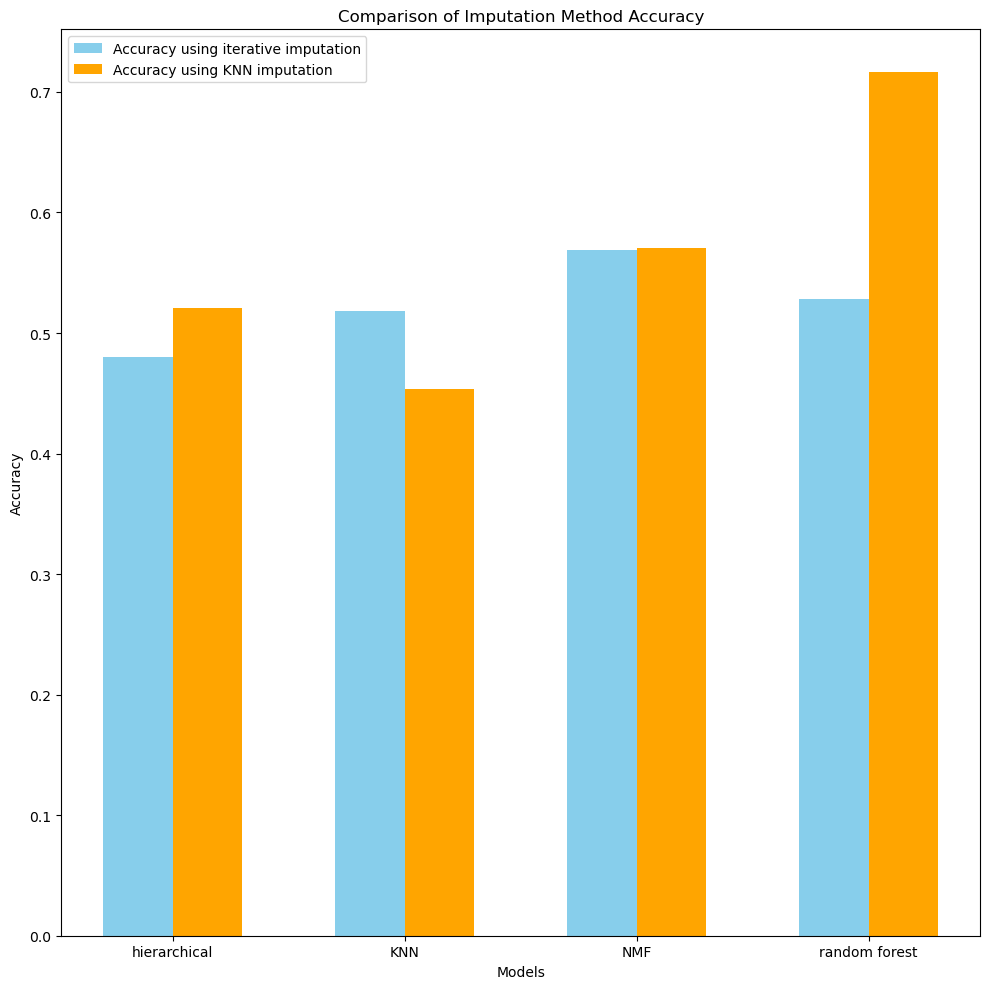

In [23]:
models = ["hierarchical", "KNN", "NMF", "random forest"]
iterative_acc = [0.48, 0.51812, 0.56909, 0.52817]
knn_acc = [0.52045, 0.45358, 0.57096, 0.71615]

# Bar width
bar_width = 0.3
index = range(len(models))

# Create the bar chart
plt.figure(figsize=(10, 10))
plt.bar(index, iterative_acc, bar_width, label='Accuracy using iterative imputation', color='skyblue')
plt.bar([i + bar_width for i in index], knn_acc, bar_width, label='Accuracy using KNN imputation', color='orange')

# Add labels and legend
plt.title("Comparison of Imputation Method Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()
plt.tight_layout()
plt.show()

This is enough that we should proceed with KNN as our chosen imputation method, as it performed similarly for most models but significantly better for random forest, which was also one of the best performing models when I attempted this Kaggle competition using a supervised learning approach.

In regard to hyperparameter tuning, I don't think we have many options or good ways of doing that and I'll explain why. With the exception of random forest, all the models are scoring around 0.5 for accuracy when we compare them to the training data, which means they are performing about as well as random predictions. If we wanted a higher accuracy, say around 0.8, it's very unlikely that we can close this gap just doing hyperparameter tuning. We may be able to look at the random forest parameters but we have another problem with hyperparameter tuning for any model. If we do imputation on the training data and split it to train and test, our models will be biased towards our own imputation. The test data will not be a good predictor of model accuracy because the impuation that was done for it is the same that was done for the training data, and we have no idea if this imputation is correct or not unless we submit results to Kaggle and see what our accuracy is. Dropping any records with missing values does not help either because we cannot drop those values on the official Kaggle test data. We need to make a prediction for each record in the test data so we must impute missing data somehow.

You can see the effect of this in the chart and screenshot above. Throughout this analysis, the random forest model has been consistently attaining accuracy of around 0.8 when splitting the training data, training the model on a portion of it, and testing the model on the other portion. But we can see above that the performance of the model is significantly lower when submitting to Kaggle. Therefore, I think there would be no benefit gained by a formal hyperparameter analysis unless we are making submissions to Kaggle at the same time and this would be cumbersome.

Instead, what we can do is make a handful of submissions to test a few different variables for the most important parameter in our KNN imputation, n_neighbors. Generally, I found that the lower this value, the higher our accuracy is. This means that the way the imputation is working is by comparing records with missing values to its neighbors and using the closest neighbor based on non-missing values to impute the missing value. I have used n_neighbors=1 in the models above and this screenshot also suggests that n_neighbors=1 gives us the highest accuracy.

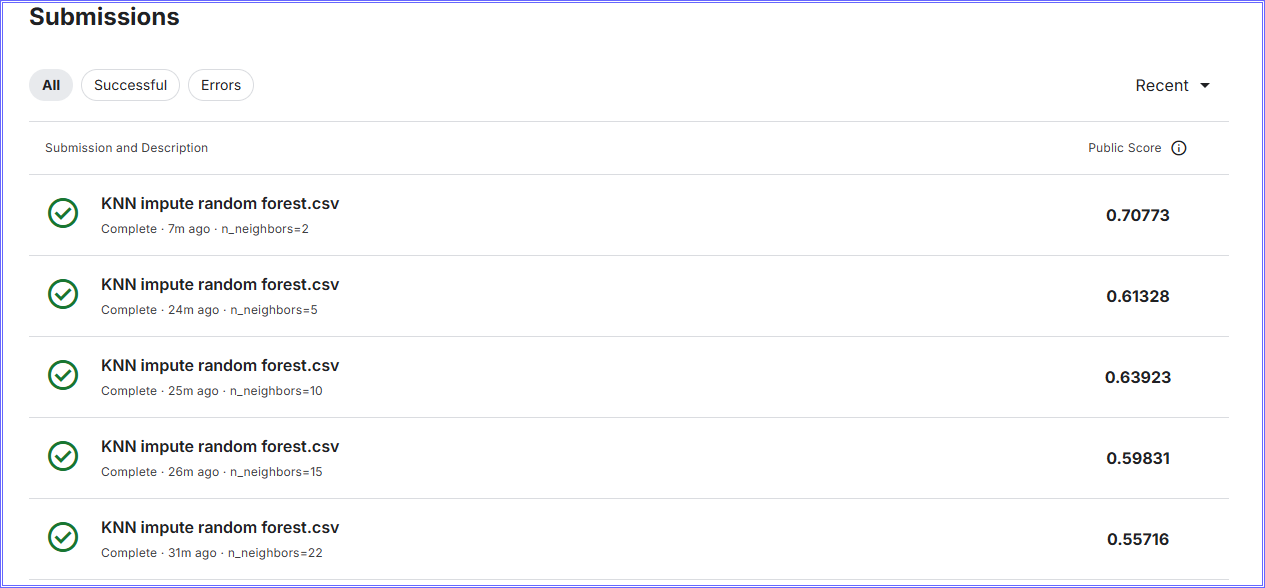

## Results and Anlaysis

While I have not used this yet in this notebook, the function below was used extensively in my preferred IDE (Spyder) to create submissions I uploaded to Kaggle shown in the screenshots above.

In [24]:
def predict_test(data_train, data_test, output_IDs, imputation_method):
    """
    Predicts test data using given training data
    """
    # initialize models
    h_model, k_model, nmf_model, forest_model = initialize_models()
    
    # train models
    h_model = model_train(h_model, data_train)
    h_perm = label_permute_compare(data_train, h_model.labels_)[0]
    
    k_model = model_train(k_model, data_train)
    k_perm = label_permute_compare(data_train, k_model.labels_)[0]
    
    nmf_model = model_train(nmf_model, data_train.drop(["Transported"], axis=1))
    nmf_perm = label_permute_compare(data_train, nmf_model.transform(data_train.drop(["Transported"], axis=1)).argmax(axis=1))[0]
    
    forest_model = model_train(forest_model, data_train.drop(["Transported"], axis=1), data_train["Transported"])
    
    # predict using models
    h_model, k_model = initialize_models()[:2]
    
    h_model.fit(data_test)
    h_pred = h_model.labels_
    h_pred = [bool(h_perm[x]) for x in h_pred]
    
    k_model.fit(data_test)
    k_pred = k_model.labels_
    k_pred = [bool(k_perm[x]) for x in k_pred]
    
    nmf_pred = nmf_model.transform(data_test).argmax(axis=1)
    nmf_pred = [bool(nmf_perm[x]) for x in nmf_pred]
    
    forest_pred = forest_model.predict(data_test)
    forest_pred = [bool(x) for x in forest_pred]
    
    # output csv files
    h_df = pd.DataFrame({
                        "PassengerId": output_IDs,
                        "Transported": h_pred
                        })
    h_df.to_csv(f"spaceship-titanic/My submissions/{imputation_method} impute, hierarchical clustering.csv", index=False)
    
    
    k_df = pd.DataFrame({
                        "PassengerId": output_IDs,
                        "Transported": k_pred
                        })
    k_df.to_csv(f"spaceship-titanic/My submissions/{imputation_method} impute, KNN clustering.csv", index=False)
    
    
    nmf_df = pd.DataFrame({
                        "PassengerId": output_IDs,
                        "Transported": nmf_pred
                        })
    nmf_df.to_csv(f"spaceship-titanic/My submissions/{imputation_method} impute, NMF.csv", index=False)
    
    
    forest_df = pd.DataFrame({
                        "PassengerId": output_IDs,
                        "Transported": forest_pred
                        })
    forest_df.to_csv(f"spaceship-titanic/My submissions/{imputation_method} impute, random forest.csv", index=False)
    
    return None

In [25]:
# use chosen method to make predictions
pass_id = data_test["PassengerId"]
clean_test = clean_data(data_test)
imputed_iterative_test = impute_data_iterative(clean_test)
imputed_KNN_test = impute_data_KNN(clean_test)

predict_test(imputed_KNN_train, imputed_KNN_test, pass_id, "KNN")
predict_test(imputed_iterative_train, imputed_iterative_test, pass_id, "iterative")

C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


We have already discussed much of my results and analysis in previous sections so I will attempt to summarize the main points here:

1. Performance in this Kaggle competition is heavily dependent on how well missing values can be imputed from patterns in the non-missing values. If you cannot impute these values successfully, it will be hard to train models to accurately make predictions.
2. Unsupervised methods can be powerful for imputing missing values but they excel in different areas depending on the values you are trying to impute. Most will be more successful with numeric data as opposed to numeric representations of textual data. In my code above, both the iterative and KNN imputers were imputing floating point numbers for categorical data where there should only be integers. I was able to force these imputations to be within a certain range for the iterative imputer but I did round them to the nearest integer for both models.
3. Hyperparameter tuning can be difficult if you are unable to determine the accuracy of your imputed values. Testing hyperparameter tuning against imputed values only serves to create bias that your model is working when it may not be.

## Final Thoughts

I believe that the biggest issue with the way I imputed missing data in my models has to do with how the iterative and KNN imputer function. Both analyze the missing data and perform calculations based on similarities or distance between points. In both cases, the imputers were trying to impute floating point numbers to categorical data that was limited to integers. I rounded these numbers, assuming that they should be approximately the correct value, but based on my best accuracy of about 0.71, I think this method was not sophisticated enough.

One method I did not try, mainly because it was more in the realm of supervised learning, was using a random forest to impute missing values. Based on what I found in this article, this method looks to be perfect for imputation on this specific data and I may test this method out once I have more free time after completing this degree program:

https://www.geeksforgeeks.org/machine-learning/handling-missing-values-with-random-forest/

I plan to approach this competition again once I have taken the deep learning class in this specialization. I believe neural networks would also be a strong candidate for imputing missing categorical data and perhaps once I've learned how to use them, I may be able to break the 0.8 threshold on the Kaggle competition and get my name higher on the leaderboard!